<a href="https://colab.research.google.com/github/JumperWacky/cycleGAN/blob/main/celeb_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# import h5py to access data
import h5py
import numpy,pandas
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch
import torch.nn as nn

In [15]:
# Check cuda
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

using cuda: Tesla T4


device(type='cuda')

In [16]:
test_flag = False
if test_flag:
  with h5py.File('/content/drive/MyDrive/Colab Notebooks/myo_gan/\
  celeba_dataset/celeba_aligned_small.h5py') as file_object:
    for group in file_object:
      dataset = file_object['img_align_celeba']
      img = numpy.array(dataset['100.jpg'])
      print(img.shape)
      plt.imshow(img, interpolation='none')
      pass

In [17]:
def generate_random_image(size=1):
  random_data = torch.rand(size)
  return random_data

def generate_random_seed(size=1):
  random_data = torch.randn(size)
  return random_data

In [18]:
# Dataset类，用于data预处理，data传入等
class CelebADataset(Dataset):
  def __init__(self, file):
    self.file_object = h5py.File(file, 'r')
    self.dataset = self.file_object['img_align_celeba']
  
  def __len__(self):
    return len(self.dataset)
  
  def __getitem__(self, index):
    if(index >= len(self.dataset)):
      raise IndexError()
    img = numpy.array(self.dataset[str(index) + '.jpg'])
    return torch.cuda.FloatTensor(img) / 255.0
  
  def plot_image(self, index):
    plt.imshow(numpy.array(self.dataset[str(index) + '.jpg']), \
          interpolation='nearest')
    pass

In [19]:
class View(nn.Module):
  def __init__(self, shape):
    super().__init__()
    self.shape = shape,
  
  def forward(self, x):
    return x.view(*self.shape)

In [20]:
# 构造鉴别器
class Discriminator(nn.Module):
  def __init__(self) -> None:
    super().__init__()

    # 定义神经网路层
    self.model = nn.Sequential(
        View(218*178*3),

        nn.Linear(218*178*3, 100),
        nn.LeakyReLU(),

        nn.LayerNorm(100),
        
        nn.Linear(100, 1),
        nn.Sigmoid()
    )

    # 创建损失函数
    self.loss_function = nn.BCELoss()

    # 创建优化器
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

    # 计数器和进程记录
    self.counter = 0
    self.progress = []

    pass
  
  def forward(self, inputs):
    return self.model(inputs)
  
  def train(self, inputs, targets):
    # 计算网络的输出值
    outputs = self.forward(inputs)
    # 计算损失值
    loss = self.loss_function(outputs, targets)

    # 梯度归零，反向传播，更新权重
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # 每隔10个训练样本增加一次计数器的值，并将损失值添加进列表的末尾
    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("dicriminator counter = ", self.counter)
      pass
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True, yticks=(0,0.25,0.5))
    pass

In [21]:
# 构造生成器
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    # 定义神经网路层
    self.model = nn.Sequential(
        nn.Linear(100, 3*10*10),
        nn.LeakyReLU(),
        
        nn.LayerNorm(3*10*10),

        nn.Linear(3*10*10, 3*218*178),
        nn.Sigmoid(),
        View((218,178,3))
    )

    # 创建优化器
    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)  # 使用的是生成器的parameters

    # 计数器和进程记录
    self.counter = 0
    self.progress = []

    pass
  
  def forward(self, inputs):
    return self.model(inputs)
  
  def train(self, D, inputs, targets):
    # 计算生成器网络输出
    g_output = self.forward(inputs)

    # 输入鉴别器
    d_output = D.forward(g_output)

    # 计算损失值
    loss = D.loss_function(d_output, targets)
    # 每训练10次增加计数器
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if (self.counter % 10000 == 0):
      print("generator counter = ", self.counter)
      pass
    
    # 梯度归零，反向传播，更新权重
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()    # 只更新生成器的parameter

    pass
  
  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns=['loss'])
    df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.',
        grid=True, yticks=(0,0.25,0.5,1.0,5.0))
    pass

In [22]:
%%time
# 测试鉴别器能够从随机噪声中区分真实数据
D = Discriminator()
D.to(device)

celeba_dataset = CelebADataset('/content/drive/MyDrive/Colab Notebooks/myo_gan/celeba_dataset/celeba_aligned_small.h5py')

if False:
  for image_data_tensor in celeba_dataset:
    # 真实数据
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # 生成数据
    D.train(generate_random_image((218, 178, 3)), torch.cuda.FloatTensor([0.0]))
    pass

CPU times: user 1.3 ms, sys: 139 ms, total: 140 ms
Wall time: 144 ms


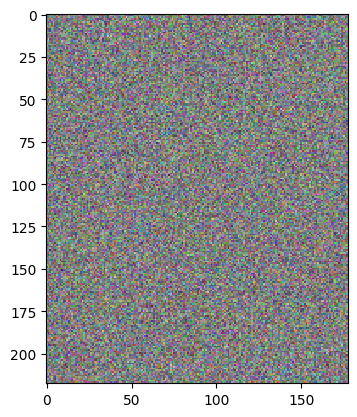

In [23]:
# 检查生成器输出
G = Generator()
# 将模型转存至CUDA设备
G.to(device)

output = G.forward(generate_random_seed(100))
img = output.detach().cpu().numpy()
plt.imshow(img, interpolation='none', cmap='Blues')

In [24]:
%%time
# 创建鉴别器和生成器

D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 6

# 训练鉴别器和生成器
for epoch in range(epochs):
  print('epoch = ', epoch + 1)
  for image_data_tensor in celeba_dataset:
    # 使用真实数据训练鉴别器
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # 使用生成数据训练鉴别器
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # 训练生成器
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass
  pass

epoch =  1
dicriminator counter =  10000
dicriminator counter =  20000
generator counter =  10000
dicriminator counter =  30000
dicriminator counter =  40000
generator counter =  20000
epoch =  2
dicriminator counter =  50000
dicriminator counter =  60000
generator counter =  30000
dicriminator counter =  70000
dicriminator counter =  80000
generator counter =  40000
epoch =  3
dicriminator counter =  90000
dicriminator counter =  100000
generator counter =  50000
dicriminator counter =  110000
dicriminator counter =  120000
generator counter =  60000
epoch =  4
dicriminator counter =  130000
dicriminator counter =  140000
generator counter =  70000
dicriminator counter =  150000
dicriminator counter =  160000
generator counter =  80000
epoch =  5
dicriminator counter =  170000
dicriminator counter =  180000
generator counter =  90000
dicriminator counter =  190000
dicriminator counter =  200000
generator counter =  100000
epoch =  6
dicriminator counter =  210000
dicriminator counter 

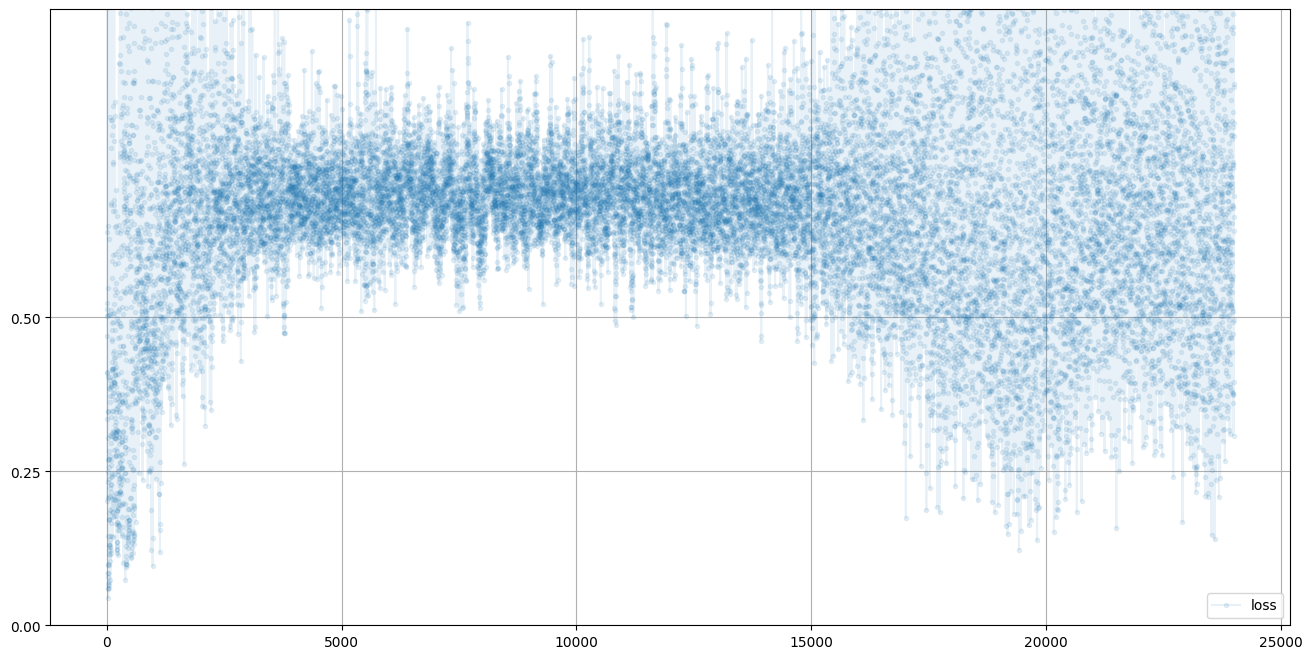

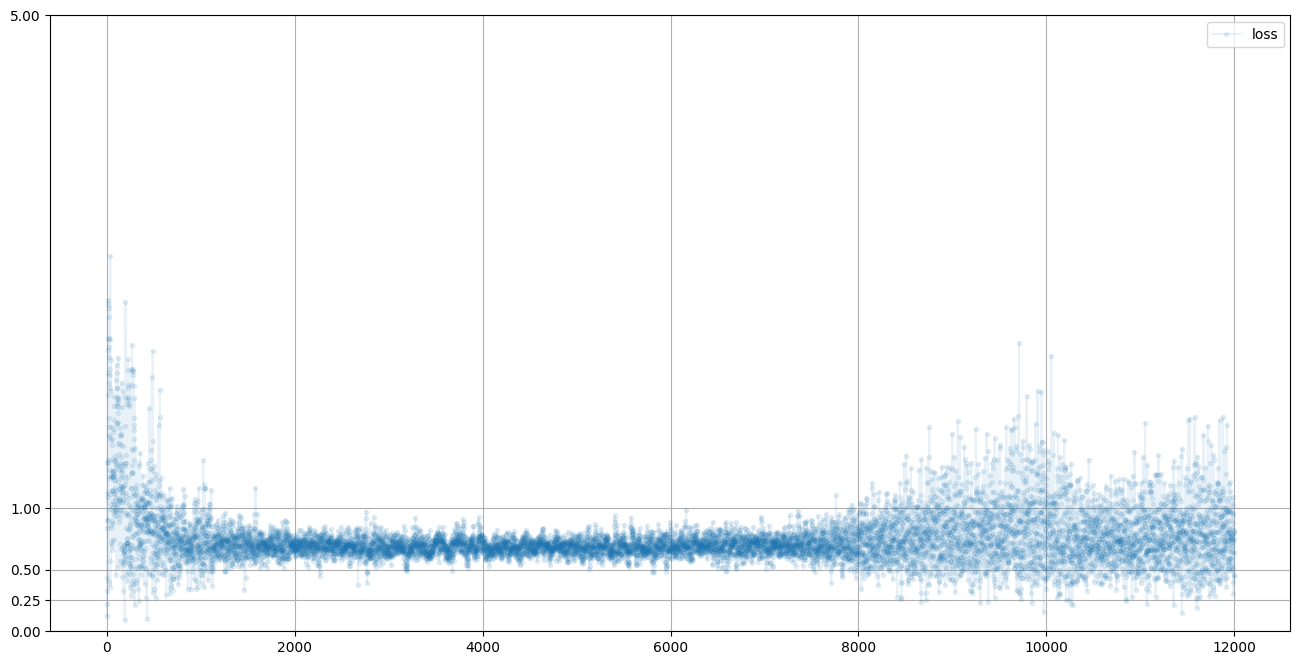

In [25]:
D.plot_progress()
G.plot_progress()

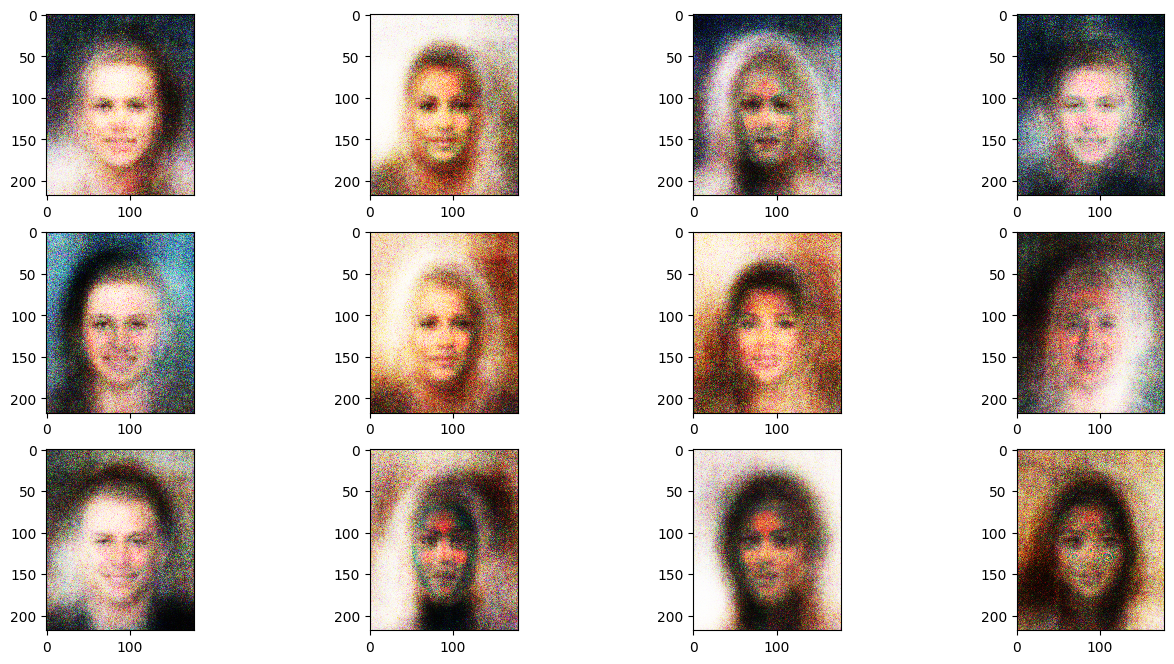

In [28]:
# 在3行4列的网格中生成图像
f, axarr = plt.subplots(3,4,figsize=(16,8))
for i in range(3):
  for j in range(4):
    output = G.forward(generate_random_seed(100))
    img = output.detach().cpu().numpy()
    axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass